# Data def etc

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/DNN')
!pip install -U kaleido

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 9.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import plotly.graph_objects as go
from rbflayer import RBFLayer, InitCentersRandom
import numpy as np
from sklearn.model_selection import train_test_split
import plotly.io as pio
pio.renderers.default = "png"
pio.templates.default = "plotly_white"



In [ ]:
######################
#Google authentication
######################

from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

In [ ]:
# Data reading

worksheet = gc.open('Data').sheet1
cols=['x','y']
table = pd.DataFrame(worksheet.get_all_values(),).T
table=pd.DataFrame(table.iloc[1:,:],dtype=float)
table.columns=cols
table
X=np.array(table['x']).reshape(-1,1)
y=np.array(table['y']).reshape(-1,1)
print(X.shape,y.shape)


(20, 1) (20, 1)


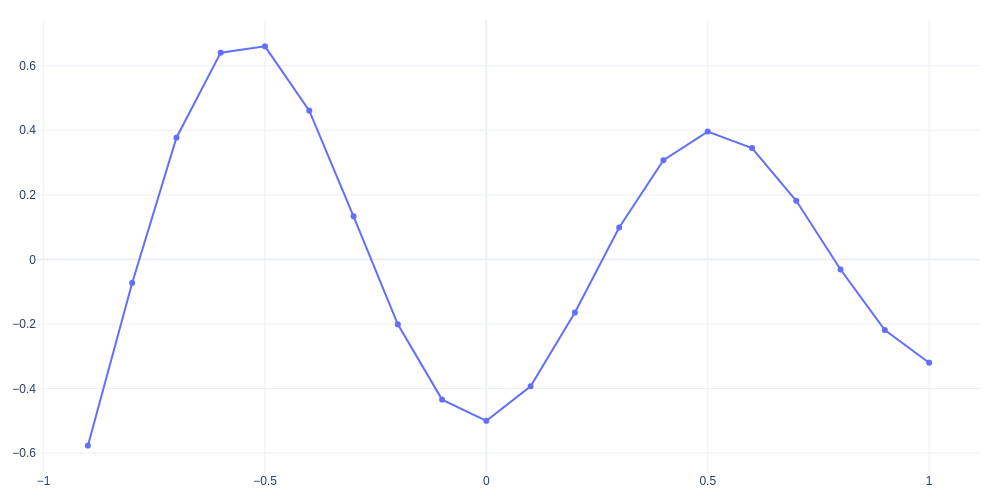

In [ ]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=X.reshape(-1),y=y.reshape(-1),mode='markers+lines'))
fig.update_layout(width=1000,
                  margin=dict(l=20, r=20, t=20, b=20))
fig.show()

# Model

Defining RBF Layer

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
from tensorflow.keras.callbacks import Callback
import warnings
class EarlyStoppingByLossVal(Callback):
    def __init__(self, monitor='val_loss', value=0.00001, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if current < self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping THR" % epoch)
            self.model.stop_training = True

In [ ]:
1497-50

1447

In [ ]:
# Cross val split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=111)

In [115]:
%%time
## Defining network parametrs
hidden_units=16
loss_func='mse' # mean squared error loss function
#opt=tf.keras.optimizers.AdamW() # Stochastic gradient descent
                                 # method with learning rate 0.1
#opt=tf.keras.optimizers.Adagrad(0.05)
opt=tf.keras.optimizers.AdamW(0.01) #was the best

metric=['mae'] # additional metrics mean absolute error

######################

model = tf.keras.Sequential()
rbflayer = RBFLayer(hidden_units,
                        initializer=InitCentersRandom(X),
                        input_shape=(1,))

model.add(rbflayer)
model.add(tf.keras.layers.Dense(1,activation='linear')) # output layer with
                                                        # 1 neuron and linear
                                                        # activation func

model.compile(loss=loss_func,
              optimizer=opt,
              metrics=metric
              )

es=[tf.keras.callbacks.EarlyStopping(min_delta=0,monitor='loss',patience=10,mode='min')]
#es=[EarlyStoppingByLossVal(monitor='loss',value=0.0001,)] # stop training


history=model.fit(X_train, y_train,
          batch_size=5,
          epochs=2000,
          verbose=0,
          callbacks=es,
          validation_data=(X_test,y_test),
          use_multiprocessing=True
          )

y_pred = model.predict(X)
model.evaluate(X,y,use_multiprocessing=True,batch_size=5)

4/4 [==============================] - 0s 3ms/step - loss: 1.6792e-04 - mae: 0.0105
CPU times: user 9.18 s, sys: 229 ms, total: 9.41 s
Wall time: 11.4 s


[0.00016792281530797482, 0.01046675443649292]

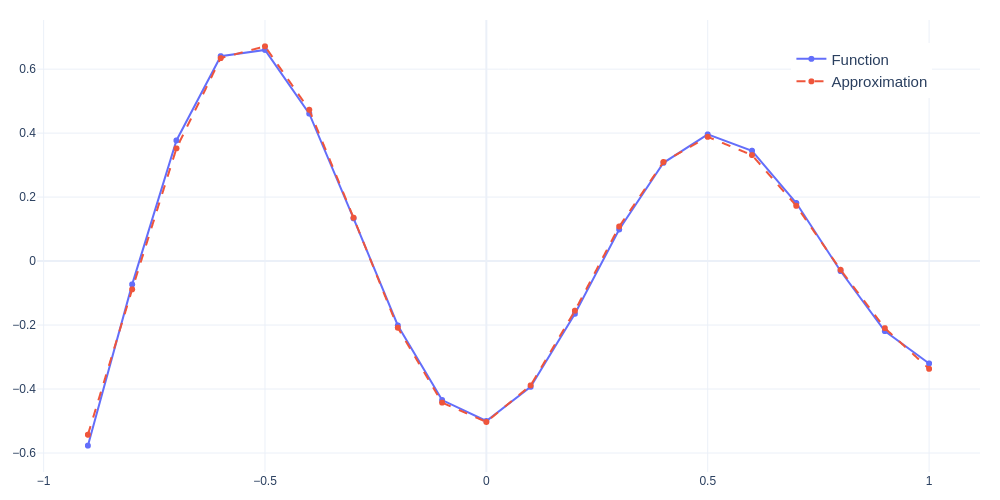

In [116]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=X.reshape(-1),
                         y=y.reshape(-1),
                         mode='lines+markers',
                         name='Function'))
fig.add_trace(go.Scatter(x=X.reshape(-1),
                         y=y_pred.reshape(-1),
                         mode='lines+markers',
                         name='Approximation',
                         line=dict(dash='dash')))
fig.update_layout(width=1000,
                  margin=dict(l=20, r=20, t=20, b=20),
                  legend=dict(
                  y=.95,
                  font=dict(size=15),
                  x=.8
                  ))

fig.show()

200

13/13 [==============================] - 0s 4ms/step


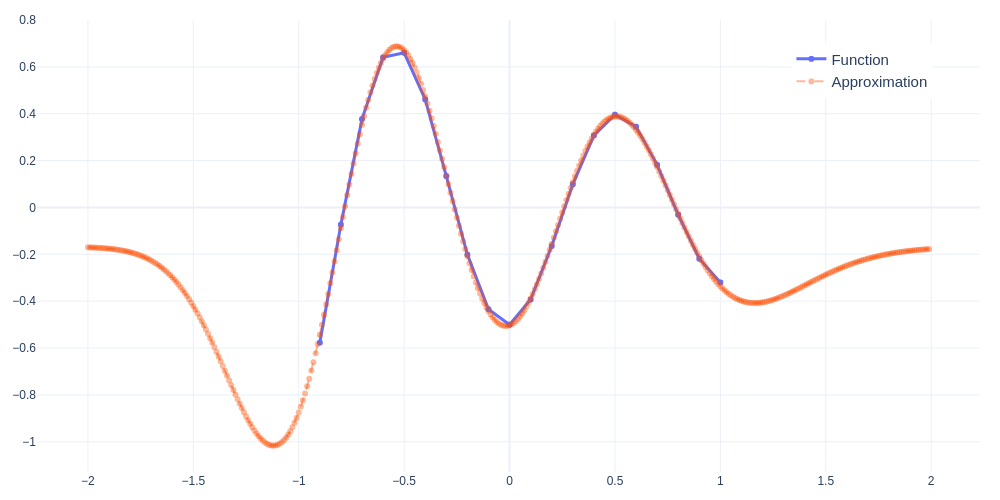

In [117]:
x_gen = np.arange(-2,2,0.01)
x_gen
y_pred_gen = model.predict(x_gen.reshape(x_gen.shape[0],1))

fig=go.Figure()
fig.add_trace(go.Scatter(x=X.reshape(-1),
                         y=y.reshape(-1),
                         mode='lines+markers',
                         name='Function',
                         line=dict(width=3)),)
fig.add_trace(go.Scatter(x=x_gen.reshape(-1),
                         y=y_pred_gen.reshape(-1),
                         mode='lines+markers',
                         name='Approximation',
                         line=dict(dash='dash',color="rgba(252,78,3,0.4)")))
fig.update_layout(width=1000,
                  margin=dict(l=20, r=20, t=20, b=20),
                  legend=dict(
                  y=.95,
                  font=dict(size=15),
                  x=.8
                  ))

fig.show()

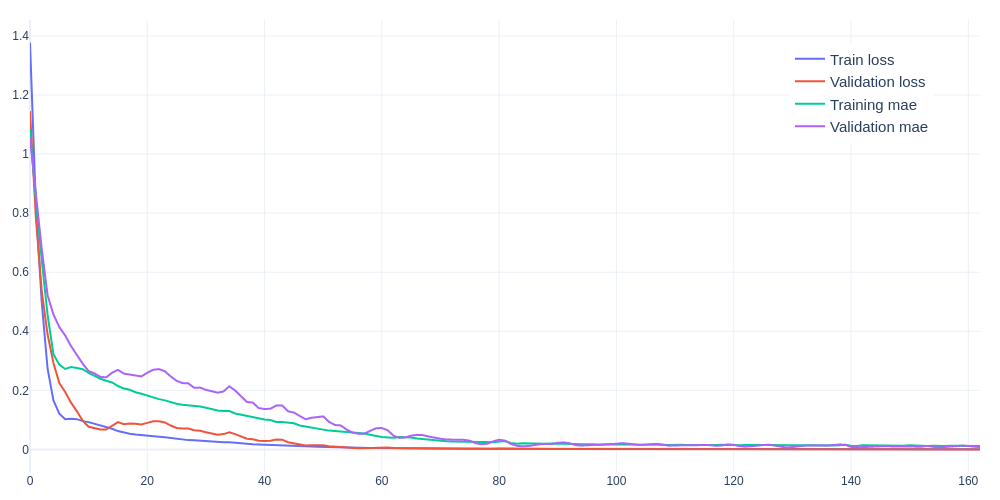

In [118]:
fig=go.Figure()
fig.add_trace(go.Scatter(y=history.history['loss'],
                         #mode='markers+lines',
                         name='Train loss'))
fig.add_trace(go.Scatter(y=history.history['val_loss'],
#                         mode='markers+lines',
                         name='Validation loss'))
fig.add_trace(go.Scatter(y=history.history['mae'],
#                         mode='markers+lines',
                         name='Training mae'))
fig.add_trace(go.Scatter(y=history.history['val_mae'],
#                         mode='markers+lines',
                         name='Validation mae'))

fig.update_layout(width=1000,
                  margin=dict(l=20, r=20, t=20, b=20),
                  legend=dict(
                  y=.95,
                  font=dict(size=15),
                  x=.8
                  ))
fig.show()

In [ ]:
model.evaluate(X,y,batch_size=20)


1/1 [==============================] - 0s 37ms/step - loss: 1.9291e-04 - mae: 0.0109


[0.0001929084537550807, 0.01092582754790783]

In [165]:
# Model perfomance with k-fold cross validation


#es=[EarlyStoppingByLossVal(monitor='val_loss',value=0.0001,)]
es=[tf.keras.callbacks.EarlyStopping(min_delta=0,monitor='val_loss',patience=20,mode='min')]


from sklearn.model_selection import KFold
folds_num=3
kfold = KFold(n_splits=folds_num, shuffle=True)
loss_per_fold=[]
val_loss_per_fold=[]
val_mae_per_fold=[]
histories=[]

for train, test in kfold.split(X,y):
  # model acrhitect
  model = tf.keras.Sequential()
  rbflayer = RBFLayer(hidden_units,
                        initializer=InitCentersRandom(X),
                        input_shape=(1,))
  opt=tf.keras.optimizers.AdamW()
  model.add(rbflayer)
  model.add(tf.keras.layers.Dense(1,activation='linear'))
  # Compile
  model.compile(loss=loss_func,
              optimizer=opt,
              metrics=metric
              )
  # Fitting
  histories.append(model.fit(X[train], y[train],
          batch_size=5,
          epochs=500,
          verbose=0,
          #callbacks=es,
          validation_data=(X[test],y[test]),
          use_multiprocessing=True
          ))
  scores=model.evaluate(X[test],y[test],verbose=0,batch_size=5)
  loss_per_fold.append(scores[0])
  val_mae_per_fold.append(scores[1])



In [154]:
print(np.mean(loss_per_fold))
print(np.std(loss_per_fold))
print(np.mean(val_mae_per_fold))
print(np.std(val_mae_per_fold))

0.0327491156446437
0.022250989423064294
0.12911460921168327
0.05222853351732655


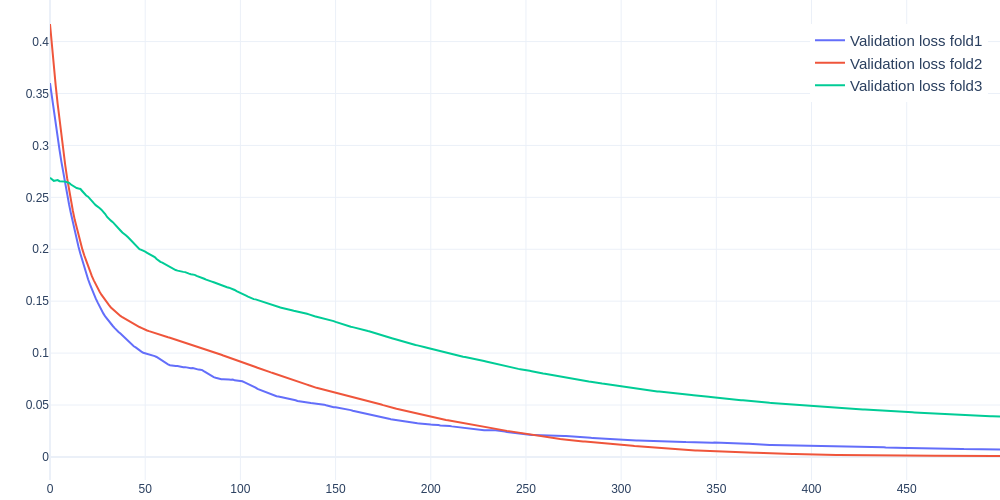

In [166]:
fig=go.Figure()
#fig.add_trace(go.Scatter(y=histories[0].history['loss'],
                         #mode='markers+lines',
#                         name='Train loss fold1'))
fig.add_trace(go.Scatter(y=histories[0].history['val_loss'],
                         #mode='markers+lines',
                         name='Validation loss fold1'))

#fig.add_trace(go.Scatter(y=histories[1].history['loss'],
                         #mode='markers+lines',
#                         name='Train loss fold2'))
fig.add_trace(go.Scatter(y=histories[1].history['val_loss'],
                         #mode='markers+lines',
                         name='Validation loss fold2'))

#fig.add_trace(go.Scatter(y=histories[2].history['loss'],
                         #mode='markers+lines',
#                         name='Train loss fold3'))
fig.add_trace(go.Scatter(y=histories[2].history['val_loss'],
                         #mode='markers+lines',
                         name='Validation loss fold3'))

#fig.add_trace(go.Scatter(y=histories[3].history['loss'],
                         #mode='markers+lines',
#                         name='Train loss fold4'))
#fig.add_trace(go.Scatter(y=histories[3].history['val_loss'],
                         #mode='markers+lines',
 #                        name='Validation loss fold4'))

#fig.add_trace(go.Scatter(y=histories[4].history['loss'],
                         #mode='markers+lines',
#                         name='Train loss fold5'))
#fig.add_trace(go.Scatter(y=histories[4].history['val_loss'],
                         #mode='markers+lines',
                         #name='Validation loss fold5'))
fig.update_layout(width=1000,
                  margin=dict(l=50, r=0, t=0, b=20),
                  legend=dict(
                  #yanchor="top",
                  #orientation="h",
                  #entrywidthmode="pixels",
                  #entrywidth=400,
                  y=.95,
                  font=dict(size=15),
                  #xanchor="right",
                  x=.8
                  ))

fig.show()

In [ ]:
histories[2].epoch[-1]

1499